## Asset Allocation
 - Black-Litterman Model
 - Risk Parity Model

### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [1]:
## 사용자 정의 모듈 업데이트시마다 자동 load

%load_ext autoreload
%autoreload 2

### 공통 라이브러리 입수
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fm

from IPython.display import display

import os
import sys

# ### 시계열 예측 라이브러리
# from sklearn.metrics import mean_squared_error
# from pmdarima import auto_arima

### 금융 / 경제 데이터
import yfinance as yf
# from fredapi import Fred

### 금융 / 경제 함수
# import numpy_financial as npf
from pyxirr import xirr

### 통계함수
from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.optimize import minimize
# from scipy.optimize import newton
# from numpy.linalg import inv

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

### 인터넷 접속 라이브러리 (한국은행,통계청)
import requests

### 그래프 셋팅 (runtime configuration parameters (rcParams))
# plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 깨짐 방지
# plt.rcParams['axes.unicode_minus'] = False    # 마이너스 부호 깨짐 방지
plt.style.use('ggplot')                       # 그래프 스타일

### 사용자 정의 모듈 import
import PM_Tool_Kit_2025 as pk


## 자산배분
1. Black Litterman Model
2. Risk Parity


### 블랙리터만 모델

- Input Parameter
 - lambda : Risk aversion parameter (3.07 in Idzorak's paper). 상수
 - wgt_bm : bm 가중치 (n*1 데이터프레임, 자산명은 인덱스로)
 - vcv : 공분산행렬 (n*n 데이터프레임, 자산명을 컬럼명과 인덱스로)
 - P,Q : View 행렬 (k*n 데이터 프레임, k는 Active View의 수)

- Output
 - Imp_Return : BM에 내재된 암묵적 기대수익률
 - BL_Rtn : BL 기대수익률 (기대수익률 + View)
 - BL_Wgt : BL 기대수익률로 산출한 포트폴리오 비중
 - 출력은 모두 데이터프레임으로


### 1. Market Implied Return 산출

 - 주어진 람다와 공분산행렬, 비중에서 Implied Return을 역산
 - Pi : Market Implied Return
 - Sigma : 공분산 행렬
 - W_mkt : BM 비중

$$
\Pi = \lambda\Sigma w_{mkt}
$$


In [2]:
### Input 데이터프레임 셋팅

# 자산군 이름
asset_name = ['US_Bonds','Int_Bonds','US_Large_Growth','US_Large_Value','US_Small_Growth','US_Small_Value','Int_Dev_Equity','Int_EM_Equity']

# 람다
lmda = 3.07   ## Risk Aversion Parameter

# BM 비중
bm_wgt = [0.1934,0.2613,0.1209,0.1209,0.0134,0.0134,0.2418,0.0349]
df_bm_wgt = pd.DataFrame(bm_wgt,index = asset_name,columns = ['BM_WGT'])

# 공분산행렬
vcv = [
    [0.001005, 0.001328, -0.000579,	-0.000675,	0.000121,	0.000128,	-0.000445,	-0.000437],
    [0.001328,	0.007277,	-0.001307,	-0.00061,	-0.002237,	-0.000989,	0.001442,	-0.001535],
    [-0.000579,	-0.001307,	0.059852,	0.027588,	0.063497,	0.023036,	0.032967,	0.048039],
    [-0.000675,	-0.00061,	0.027588,	0.029609,	0.026572,	0.021465,	0.020697,	0.029854],
    [0.000121,	-0.002237,	0.063497,	0.026572,	0.102488,	0.042744,	0.039943,	0.065994],
    [0.000128,	-0.000989,	0.023036,	0.021465,	0.042744,	0.032056,	0.019881,	0.032235],
    [-0.000445,	0.001442,	0.032967,	0.020697,	0.039943,	0.019881,	0.028355,	0.035064],
    [-0.000437,	-0.001535,	0.048039,	0.029854,	0.065994,	0.032235,	0.035064,	0.079958]
    ]
df_vcv = pd.DataFrame(vcv,index = asset_name,columns = asset_name)

#### Implied Return : 주어진 람다와 공분산행렬, 비중에서 Implied Return을 역산
Imp_Rtn = lmda * df_vcv @ df_bm_wgt
Imp_Rtn.columns = ['Implied_Return']

print('benchmark weight is \n')
display(df_bm_wgt.style.format("{:.2%}"))
print('\n')
print('covariance matrix is \n')
display(df_vcv)
print('\n')
print('Market Implied Return is \n')
Imp_Rtn.style.format("{:.2%}")


benchmark weight is 



,BM_WGT
US_Bonds,19.34%
Int_Bonds,26.13%
US_Large_Growth,12.09%
US_Large_Value,12.09%
US_Small_Growth,1.34%
US_Small_Value,1.34%
Int_Dev_Equity,24.18%
Int_EM_Equity,3.49%




covariance matrix is 



,US_Bonds,Int_Bonds,US_Large_Growth,US_Large_Value,US_Small_Growth,US_Small_Value,Int_Dev_Equity,Int_EM_Equity
US_Bonds,0.001005,0.001328,-0.000579,-0.000675,0.000121,0.000128,-0.000445,-0.000437
Int_Bonds,0.001328,0.007277,-0.001307,-0.000610,-0.002237,-0.000989,0.001442,-0.001535
US_Large_Growth,-0.000579,-0.001307,0.059852,0.027588,0.063497,0.023036,0.032967,0.048039
US_Large_Value,-0.000675,-0.000610,0.027588,0.029609,0.026572,0.021465,0.020697,0.029854
US_Small_Growth,0.000121,-0.002237,0.063497,0.026572,0.102488,0.042744,0.039943,0.065994
US_Small_Value,0.000128,-0.000989,0.023036,0.021465,0.042744,0.032056,0.019881,0.032235
Int_Dev_Equity,-0.000445,0.001442,0.032967,0.020697,0.039943,0.019881,0.028355,0.035064
Int_EM_Equity,-0.000437,-0.001535,0.048039,0.029854,0.065994,0.032235,0.035064,0.079958




Market Implied Return is 



,Implied_Return
US_Bonds,0.08%
Int_Bonds,0.67%
US_Large_Growth,6.42%
US_Large_Value,4.09%
US_Small_Growth,7.44%
US_Small_Value,3.71%
Int_Dev_Equity,4.81%
Int_EM_Equity,6.61%


In [3]:
### Market Implied Rate 산출








In [4]:

### View Matrix(P)
# View 1 : International Developed Equity 의 기대 수익률 5.25%
# View 2 : international Bonds의 기대수익률이 US Bonds의 기대수익률 보다 25bp 높음
# View 3 : US Large Growth와 Small Growth가 US Large Value와 US Small Value를 2%p 아웃퍼폼. Largecap과 Smallcap의 비중은 각각 9:1

P = [
    [0,0,0,0,0,0,1,0],
    [-1,1,0,0,0,0,0,0],
    [0,0,0.9,-0.9,0.1,-0.1,0,0]
    ]

Q = [
    [0.0525],
    [0.0025],
    [0.02]
    ]

tau = 0.025

df_P = pd.DataFrame(P,index = ['View1','View2','View3'],columns = asset_name)
df_Q = pd.DataFrame(Q,index = ['View1','View2','View3'],columns = ['View_Rtn'])
display(df_P)
print('\n')
display(df_Q.style.format("{:.2%}"))

,US_Bonds,Int_Bonds,US_Large_Growth,US_Large_Value,US_Small_Growth,US_Small_Value,Int_Dev_Equity,Int_EM_Equity
View1,0,0,0.0,0.0,0.0,0.0,1,0
View2,-1,1,0.0,0.0,0.0,0.0,0,0
View3,0,0,0.9,-0.9,0.1,-0.1,0,0


,View_Rtn
View1,5.25%
View2,0.25%
View3,2.00%


In [5]:
### View Matrix 작성






### Black-Litterman 기대수익률


\begin{align}
    \Pi_{BL} &= \left[(\tau \Sigma)^{-1} + P'\Omega^{-1}P\right]^{-1}
            \left[(\tau \Sigma)^{-1}\Pi + P'\Omega^{-1}Q\right] \\
    where \\
    \Omega &=
\begin{bmatrix}
(\mathbf{p_1} \Sigma \mathbf{p_1'}) * \tau & 0 & 0 & 0 \\
0 & (\mathbf{p_2} \Sigma \mathbf{p_2'}) * \tau & \ 0 & 0 \\
0 & 0 & \text{...} & 0 \\
0 & 0 & 0 & (\mathbf{p_k} \Sigma \mathbf{p_k'}) * \tau
\end{bmatrix} \\
\\
\\
w_{BL} &= (\lambda \Sigma)^{-1}\Pi_{BL}
\end{align}



In [6]:

#### Omega
Omega = tau * (df_P @ df_vcv @ df_P.T) * np.eye(3)

#### inverse(Omega)
Omega_1 = np.linalg.inv(Omega)

#### inverse(tau*Sigma)
tau_sigma_1 = np.linalg.inv(tau * df_vcv)

#### 블랙-리터만 기대수익률
BL_ER =  pd.DataFrame(
    np.linalg.inv(tau_sigma_1 + df_P.T.values @ Omega_1 @ df_P.values) @ (tau_sigma_1 @ Imp_Rtn.values + df_P.T.values @ Omega_1 @ df_Q.values),
    columns = ['BL_ER'],
    index = asset_name
    )

#### 블랙-리터만 자산배분
BL_WGT = pd.DataFrame(
    np.linalg.inv(lmda * df_vcv.values) @ BL_ER.values,
    columns = ['BL_WGT'],
    index = asset_name
    )

BL_OUT = pd.concat([df_bm_wgt,Imp_Rtn,BL_ER,BL_WGT],axis = 1)
display(BL_OUT.style.format("{:.2%}"))


,BM_WGT,Implied_Return,BL_ER,BL_WGT
US_Bonds,19.34%,0.08%,0.07%,29.89%
Int_Bonds,26.13%,0.67%,0.50%,15.58%
US_Large_Growth,12.09%,6.42%,6.50%,9.35%
US_Large_Value,12.09%,4.09%,4.33%,14.83%
US_Small_Growth,1.34%,7.44%,7.59%,1.04%
US_Small_Value,1.34%,3.71%,3.94%,1.64%
Int_Dev_Equity,24.18%,4.81%,4.94%,27.77%
Int_EM_Equity,3.49%,6.61%,6.84%,3.49%


In [7]:
#### Black Litterman 기대수익률 및 자산배분








## Risk Parity
- 자산군별 포트폴리오 분산에의 기여도 (=위험기여도) 산출
- 모든 자산의 위험기여도가 동일해지는 자산배분 산출
- S&P500 10개 업종 Risk Parity 자산배분과 S&P500의 성과 비교

In [8]:
### 분석기간
stdt = '2005-01-01'
ltdt = '2024-12-31'

### 데이터 입수 (S&P500 업종별 지수)
sec_data = yf.download(['^SP500-1010','^SP500-15','^SP500-20','^SP500-25','^SP500-30','^SP500-35','^SP500-40','^SP500-45','^SP500-50','^SP500-55'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  # Yahoo finance는 end시점 전일까지의 데이터를 가져오기 떄문에 하루를 더해 줌

sec_data = sec_data.tz_localize(None)['Adj Close']

### 데이터 입수 (S&P500 지수)
sp500 = yf.download(['^GSPC'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  # Yahoo finance는 end시점 전일까지의 데이터를 가져오기 떄문에 하루를 더해 줌

sp500 = sp500.tz_localize(None)['Adj Close']


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
### 분산, 상관관계, 표준편차 (sec_data)

r_stk = pk.get_return(sec_data,freq = 'W')
r_stk_vcv = r_stk.cov()
r_stk_corr = r_stk.corr()
r_stk_std = r_stk.std()

### S&P500의 수익률
r_sp500 = pk.get_return(sp500,freq = 'W')

In [10]:
### 위험기여도 및 Risk Parity 자산배분 계산













In [11]:
#------------------------------------------------------------------#
#                 함수 작성                                         #
#------------------------------------------------------------------#

### 각 자산의 위험 기여도 산출

def risk_contribution(wgt,vcv):

  pf_var = (wgt.T @ vcv @ wgt)
  rc1 = wgt.T * (vcv @ wgt)
  rc2 = rc1 / pf_var

  return rc2

### 각 자산의 위험 기여도가 동일해 지는 자산배분

def risk_parity(vcv):

    """
    risk parity (risk contribution의 sum square를 최소화)
    """
    constraint_1 = {'type': 'eq',
                    'fun': lambda weight: np.sum(weight) - 1
                    }

    n_asset = vcv.shape[0]
    er = np.repeat(1, n_asset)
    rf = 0.0
    init_guess = np.repeat(1/n_asset,n_asset)

    def min_squared_risk_contribution(weight, vcv):

        rc = risk_contribution(weight, vcv)
        trc =np.repeat(1/len(rc),len(rc))

        return np.sum((rc-trc)**2)

    bnds = ((0.0, 1.0),) * n_asset

    result = minimize(fun=min_squared_risk_contribution,
                      x0=init_guess,
                      args=vcv,
                      method='SLSQP',
                      options={'disp': False},
                      constraints=constraint_1,
                      bounds=bnds)

    return result.x


### Risk Parity 자산배분 산출

In [12]:
### Risk Parity 자산배분 결과
### risk_parity(vcv)

display(risk_parity(r_stk_vcv))

array([0.08121878, 0.08198487, 0.0859233 , 0.08582191, 0.14680819,
       0.12186362, 0.07061384, 0.09344055, 0.10956134, 0.1227636 ])

### Back-Test

- test period : 2005년~2023년
- 방법
1. 매 6개월 마다 과거 6개월 데이터를 이용해 공분산 행렬 산출
2. 각 공분산 행렬을 사용하여 Risk Parity 자산배분을 산출
3. 다음 6개월간의 성과를 측정

Ex) \
(1) 2005.1.1 ~ 2005.6.30일간의 데이터로 공분산 산출 \
(2) Risk Parity 자산배분 \
(3) 2005.7.1~2005.12.31일간의 운용성과 산출
(4) 동일한 과정을 2023년 12.31일까지 반복 실행하여 누적성과를 S&P500과 비교


In [13]:
### 매 6개월 간격으로 공분산 행렬 및 Risk Parity Weight

### 기간 설정
vcv_from = pd.date_range(start = '2004-12-31', end = '2023-12-31', freq = '6ME')
vcv_period = pd.DataFrame({'vcv_start': vcv_from,'vcv_end': vcv_from.shift(1)})

risk_parity_wgt = pd.DataFrame()

### 각 기간마다 공분산 산출 및 Risk Parity Weight 산출

for i in range(0,len(vcv_period)):


  # 기간 정의
  vcv_start = vcv_period.loc[i,'vcv_start']
  vcv_end = vcv_period.loc[i,'vcv_end']

  # 공분산행렬
  r_train = r_stk.loc[vcv_start : vcv_end]
  vcv_train = r_train.cov()

  # Risk Parity 자산배분 비중
  train_wgt = risk_parity(vcv_train)
  train_wgt_T = train_wgt.reshape(1,len(train_wgt))

  # 산출결과 누적
  df_train_wgt = pd.DataFrame(train_wgt_T,columns = vcv_train.columns,index = [vcv_end])
  risk_parity_wgt = pd.concat([risk_parity_wgt,df_train_wgt],axis=0)

display(risk_parity_wgt)






Ticker,^SP500-1010,^SP500-15,^SP500-20,^SP500-25,^SP500-30,^SP500-35,^SP500-40,^SP500-45,^SP500-50,^SP500-55
2005-06-30,0.050056,0.052285,0.090732,0.082037,0.134171,0.198085,0.091217,0.087751,0.091066,0.122598
2005-12-31,0.060846,0.080083,0.123511,0.092595,0.126259,0.126229,0.108986,0.095832,0.093454,0.092206
2006-06-30,0.058127,0.057692,0.090240,0.122074,0.163984,0.132785,0.088599,0.072839,0.106241,0.107418
2006-12-31,0.101243,0.077691,0.079101,0.071527,0.173594,0.112991,0.097964,0.060320,0.065753,0.159817
2007-06-30,0.073799,0.094134,0.102200,0.090968,0.122308,0.106777,0.085480,0.106494,0.122704,0.095136
2007-12-31,0.090308,0.060458,0.103634,0.079340,0.160331,0.120467,0.064179,0.092821,0.136799,0.091663
2008-06-30,0.111366,0.092319,0.084011,0.078063,0.149516,0.150974,0.056834,0.090438,0.074555,0.111924
2008-12-31,0.084341,0.083204,0.105331,0.076526,0.144083,0.118566,0.060311,0.105107,0.092213,0.130317
2009-06-30,0.088523,0.085162,0.068979,0.079439,0.166008,0.129689,0.039264,0.102108,0.121811,0.119018
2009-12-31,0.069144,0.054996,0.068471,0.073615,0.185609,0.130179,0.064720,0.088125,0.154658,0.110483


In [14]:
### (실습) 매 6개월마다 포트폴리오의 공분산행렬을 구하고, Risk Parity 비중 산출










In [15]:
### 비중, 수익률, 기간을 입력하면 포트폴리오 누적 밸류 계산하는 함수

def back_test(wgt,rtn,test_from,test_to):

  # 백테스트 기간의 수익률
  rtn_bt = rtn.loc[test_from :test_to]

  # 백테스트 기간의 누적 수익률
  cum_rtn_bt = (1+rtn_bt).cumprod()

  # 누적수익률 * 기초 비중
  cum_rtn_bt_wgt = cum_rtn_bt * wgt.to_numpy()

  # 자산별 누적수익률의 합 = 포트폴리오 가치
  cum_rtn_sum = cum_rtn_bt_wgt.sum(axis=1)

  return cum_rtn_sum, cum_rtn_bt_wgt

In [16]:
### back-test 함수를 여러개의 wgt에 대해 반복실행

def back_test_rebal(df_wgt,rtn,forward_months):

  # back_test함수를 반복실행하여 결과를 누적
  for i in range(0,len(df_wgt)):

    # df_wgt 에서 wgt하나 선택
    wgt = pd.DataFrame(df_wgt.iloc[[i]])
    wgt_dt = wgt.index[0]

    # wgt의 해당일에서 해당일 -6일 (첫날 포함하기 위한)~ 향후 n개월의 수익률 추출
    test_from = wgt_dt + pd.DateOffset(days=-6)
    test_to = wgt_dt + pd.DateOffset(months=forward_months)

    # 해당 기간의 누적수익률 및 포트폴리오 가치
    cum_rtn_sum,cum_rtn_bt_wgt = back_test(wgt,rtn,test_from,test_to)

    # 포트폴리오 수익률
    rtn_rp = cum_rtn_sum.pct_change().dropna()

    # 기간 전체의 수익률 연결
    if i == 0:
      whole_period_rtn_rp = rtn_rp
    else:
      whole_period_rtn_rp = pd.concat([whole_period_rtn_rp,rtn_rp],axis=0)

  return (1+whole_period_rtn_rp).cumprod()

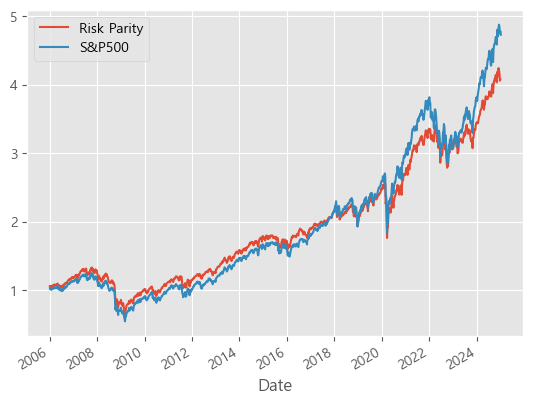

In [17]:
### 함수를 적용하여 S&P500과 Risk Parity의 성과를 비교

sp500_rp = back_test_rebal(risk_parity_wgt,r_stk,6)
sp500_rp.loc['2006':].plot(label = 'Risk Parity')
(1+r_sp500['^GSPC'].loc['2006':]).cumprod().plot(label = 'S&P500')
plt.legend()
plt.show()

### 주식 - 채권 50:50 포트폴리오와 Risk Parity 전략의 성과 비교

In [18]:
### 데이터 입수 (주식/채권)
sb_data = yf.download(['SPY','AGG'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)  # Yahoo finance는 end시점 전일까지의 데이터를 가져오기 떄문에 하루를 더해 줌

sb_data = sb_data.tz_localize(None)['Adj Close']

### 수익률, 공분산, 상관관계, 표준편차
r_sb = pk.get_return(sb_data, freq = 'W')
r_sb_cov = r_sb.cov()
r_sb_corr = r_sb.corr()
r_sb_std = r_sb.std()

display(pk.fs_desc(sb_data,freq = 'W',rf = 0.03))


[*********************100%***********************]  2 of 2 completed


Ticker,AGG,SPY
Annual_Rtn,0.029185,0.103703
Annual_Std,0.052492,0.176492
Normal VaR,-0.011393,-0.038056
C-F VaR,-0.008532,-0.039817
Historical VaR,-0.009571,-0.038152
MDD,-0.18433,-0.551894
Sharpe,-0.01552,0.417598


In [19]:
display(r_sb)

Ticker,AGG,SPY
Date,,
2005-01-14,0.001174,-0.001688
2005-01-21,0.005957,-0.012348
2005-01-28,0.000000,0.005566
2005-02-04,0.003498,0.023844
2005-02-11,-0.000292,0.004491
...,...,...
2024-12-06,0.004470,0.008730
2024-12-13,-0.014195,-0.005923
2024-12-20,-0.006601,-0.018322


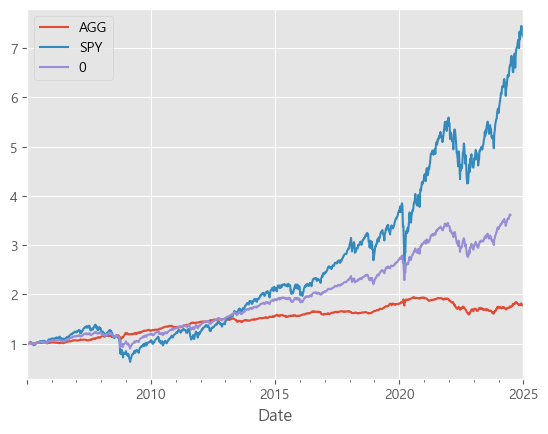

In [20]:
### 50:50 전략 성과

### 기간 설정
wgt_dt = pd.date_range(start = '2004-12-31', end = '2023-12-31', freq = '6ME')

stock_wgt = 0.5

fixed_wgt = pd.DataFrame({'stock_wgt':stock_wgt,
                          'bond_wgt': 1- stock_wgt},index = wgt_dt)

pf_fixed_wgt = back_test_rebal(fixed_wgt,r_sb,6)

cum_r_sb = (1+r_sb).cumprod()
cum_r_sb = pd.concat([cum_r_sb,pf_fixed_wgt], axis = 1)
cum_r_sb.plot();

In [21]:
### 매 6개월 간격으로 공분산 행렬 및 Risk Parity Weight

### 기간 설정
vcv_from = pd.date_range(start = '2004-12-31', end = '2023-12-31', freq = '6ME')
vcv_period = pd.DataFrame({'vcv_start': vcv_from,'vcv_end': vcv_from.shift(1)})

risk_parity_wgt = pd.DataFrame()

### 각 기간마다 공분산 산출 및 Risk Parity Weight 산출

for i in range(0,len(vcv_period)):

  # 기간 정의
  vcv_start = vcv_period.loc[i,'vcv_start']
  vcv_end = vcv_period.loc[i,'vcv_end']

  # 공분산행렬
  r_ = r_sb.loc[vcv_start : vcv_end]
  vcv_ = r_.cov()

  # Risk Parity 자산배분 비중
  rp_wgt = risk_parity(vcv_)
  rp_wgt_T = rp_wgt.reshape(1,len(rp_wgt))

  # 산출결과 누적
  df_rp_wgt = pd.DataFrame(rp_wgt_T,columns = vcv_.columns,index = [vcv_end])
  risk_parity_wgt = pd.concat([risk_parity_wgt,df_rp_wgt],axis=0)

display(risk_parity_wgt)


Ticker,AGG,SPY
2005-06-30,7.649254e-01,0.235075
2005-12-31,7.335845e-01,0.266415
2006-06-30,8.105228e-01,0.189477
2006-12-31,7.873387e-01,0.212661
2007-06-30,8.146571e-01,0.185343
2007-12-31,8.096114e-01,0.190389
2008-06-30,7.963835e-01,0.203616
2008-12-31,7.050027e-01,0.294997
2009-06-30,8.530649e-01,0.146935
2009-12-31,0.000000e+00,1.000000


,0
Annual_Rtn,0.065445
Annual_Std,0.086285
Normal VaR,-0.01839
C-F VaR,-0.01914
Historical VaR,-0.015014
MDD,-0.177926
Sharpe,0.410786


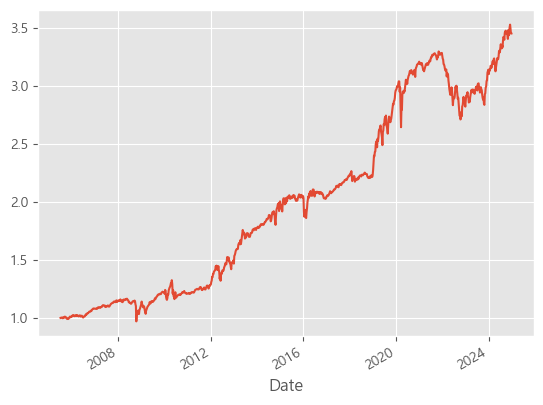

In [22]:
### Risk Parity 포트폴리오의 성과

pf_rp = back_test_rebal(risk_parity_wgt,r_sb,6)
pf_rp.plot();
display(pk.fs_desc(pf_rp,freq = 'W',rf = 0.03))

,50:50,Risk Parity
Annual_Rtn,0.068306,0.064505
Annual_Std,0.095498,0.08671
Normal VaR,-0.020423,-0.018503
C-F VaR,-0.020932,-0.019281
Historical VaR,-0.019095,-0.015104
MDD,-0.272997,-0.177926
Sharpe,0.401118,0.397932


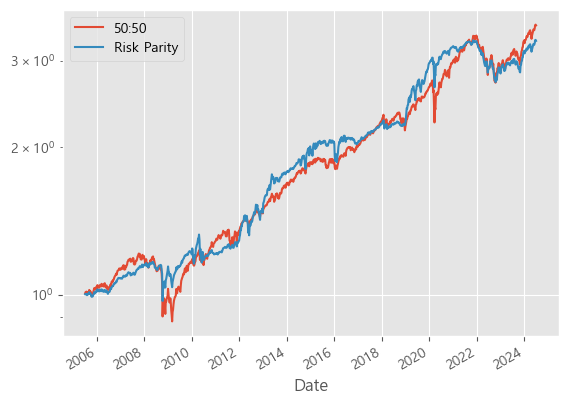

In [23]:
### 50:50 과 Risk Parity의 비교

df_compare_ = pd.concat([pf_fixed_wgt,pf_rp],axis = 1).dropna()
r_df_compare_ = df_compare_.pct_change().dropna()
df_compare = (1+r_df_compare_).cumprod()
df_compare.columns = ['50:50','Risk Parity']
df_compare.plot(logy = True);

display(pk.fs_desc(df_compare,freq = 'W',rf = 0.03))